In [1]:
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

from models import climate
reload(climate)

<module 'models.climate' from '/media/dwu402/Data/self-harm/models/climate.py'>

In [2]:
from scipy import integrate

parameters = [0.01, 0.6, 1.5, 3.5, 0.9, 0.2, 180]
def modelfn(t, y):
    return climate.model(t, y, parameters)

infected_fraction = 1e-5

solution = integrate.solve_ivp(modelfn, [1, 100], [1-infected_fraction, infected_fraction, 0, 79.3, 0], max_step=1/12)

In [3]:
solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 7136
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([  1.        ,   1.0282656 ,   1.11159894, ...,  99.86159894,
        99.94493227, 100.        ])
 t_events: None
        y: array([[9.99990000e-01, 9.98589413e-01, 9.94608975e-01, ...,
        6.06666667e-01, 6.06666667e-01, 6.06666667e-01],
       [1.00000000e-05, 1.01678582e-05, 1.06757080e-05, ...,
        1.38807947e-01, 1.38807947e-01, 1.38807947e-01],
       [0.00000000e+00, 1.40041916e-03, 5.38034972e-03, ...,
        2.54525386e-01, 2.54525386e-01, 2.54525386e-01],
       [7.93000000e+01, 7.98343727e+01, 8.21163528e+01, ...,
        7.90382408e+01, 7.87077055e+01, 7.93000002e+01],
       [0.00000000e+00, 4.15591284e-07, 1.55752737e-06, ...,
        2.09558195e-01, 2.09661810e-01, 2.09730233e-01]])

In [4]:
T = solution.t
S, I, R, Q, L = solution.y

Text(0.5, 1.0, 'Propotion of population as susceptible, infected and recovered')

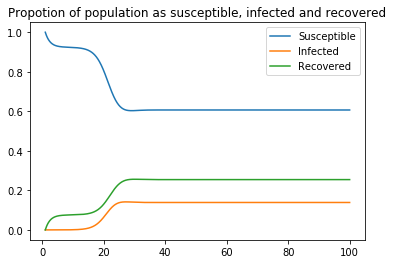

In [5]:
plt.plot(T, S, T, I, T, R)
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.title("Propotion of population as susceptible, infected and recovered")

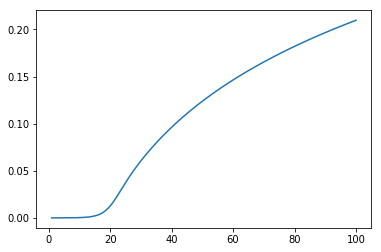

In [6]:
plt.plot(T, L)

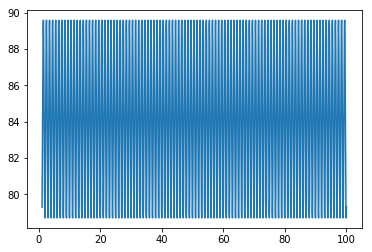

In [7]:
plt.plot(T, Q)

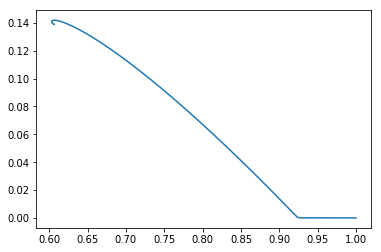

In [8]:
plt.plot(S, I)

In [9]:
climate.COEFS

array([ 5.49631853,  1.41545858, 82.76084493])

In [10]:
climate.DQ??